# Environment Setup

In [ ]:
import torch
from torch.utils import data
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

##Data

In [ ]:
class ExpDataset(Dataset):
  def __init__(self, data):
    assert data.size(dim=1) == 2
    self.data = data

  def __len__(self):
    return self.data.size(dim=0)

  def __getitem__(self, idx):
    return (torch.tensor([self.data[idx][0]],dtype=torch.float32),
           torch.tensor([self.data[idx][1]], dtype=torch.float32))

In [ ]:
def plot_data(data,title=''):
  df = pd.DataFrame(data=data,columns=['X','y'])
  sns.scatterplot(data=df,x='X',y='y',s=1.5).set(title=f"{title} {data.shape}")

def plot_loss(data):
  df = pd.DataFrame(data=data,columns=['epoch','training','validation'])
  df_melted = df.melt(id_vars=['epoch'], 
                      value_vars=['training', 'validation'],
                      var_name='Loss Type',
                      value_name='loss')
  sns.lineplot(data=df_melted,x='epoch',y='loss',hue='Loss Type')

def plot_predictions(data):
  df = pd.DataFrame(data=data,columns=['X','target','predicted'])
  df_melted = df.melt(id_vars=['X'], 
                      value_vars=['target', 'predicted'],
                      var_name='y type',
                      value_name='y')
  sns.scatterplot(data=df_melted,x='X',y='y',hue='y type',s=1.5).set(title="Model Predictions")

Generate example data

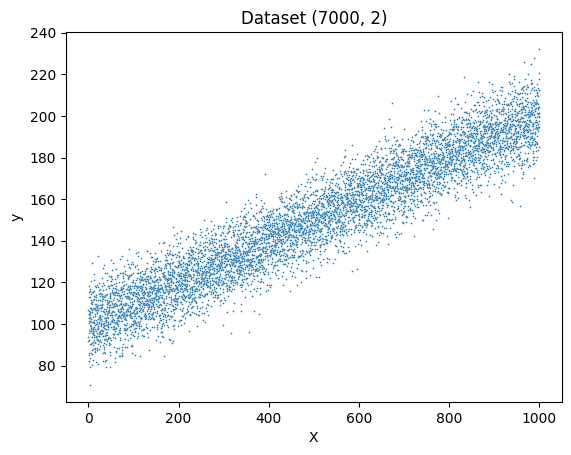

In [ ]:
n = 7000
intercept = 100
slope = 0.1
rng = default_rng()
X = np.linspace(start=0,stop=1e3,num=n,dtype='float32')
Y = np.add(slope*X, intercept+rng.normal(loc=0, scale=10, size=n), dtype='float32')

data = np.stack((X,Y), 1)
plot_data(data,"Dataset")

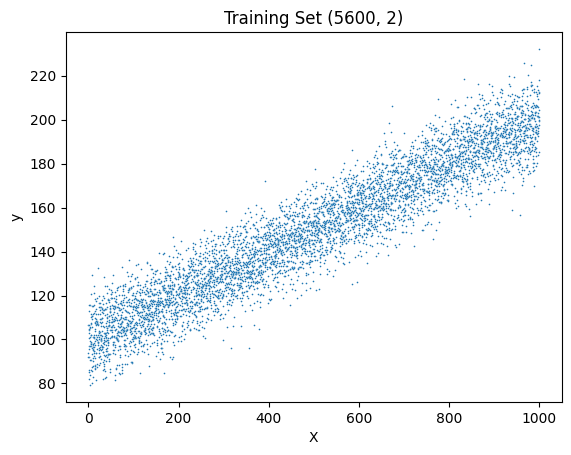

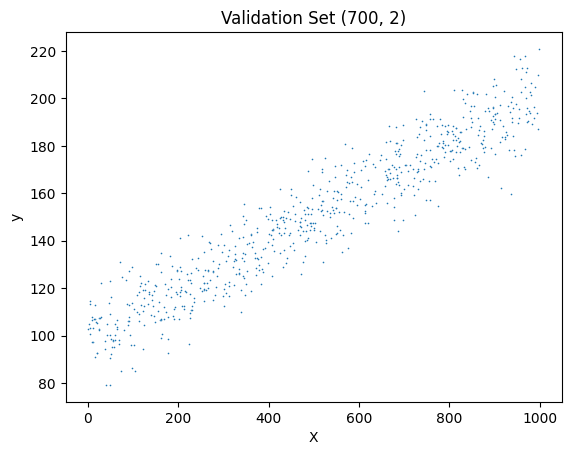

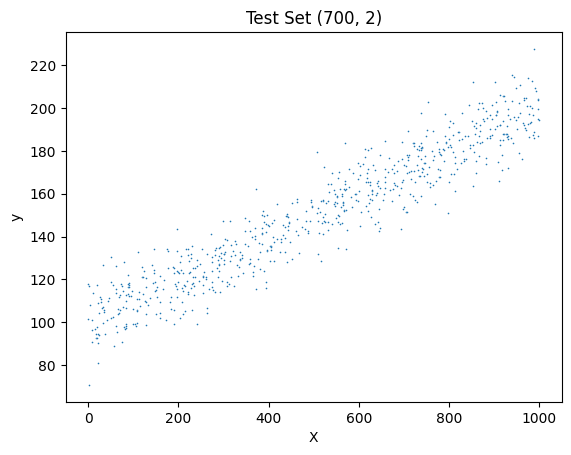

In [ ]:
train_data, test_valid_data = train_test_split(data,train_size=0.8)
valid_data, test_data = train_test_split(test_valid_data,train_size=0.5)

for i, (d, t) in enumerate([(train_data,"Training Set"),
                          (valid_data,"Validation Set"),
                          (test_data,"Test Set")]):
  plt.figure(i)
  plot_data(d,t)

In [ ]:
batch_size = 512

training_data = ExpDataset(torch.from_numpy(train_data))
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

validation_data = ExpDataset(torch.from_numpy(valid_data))
validation_dataloader = DataLoader(validation_data, batch_size=valid_data.shape[0], shuffle=True)

testing_data = ExpDataset(torch.from_numpy(test_data))
test_dataloader = DataLoader(testing_data, batch_size=test_data.shape[0], shuffle=True)

##Model Definition

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


Using cpu device


In [ ]:
class LinearRegression(nn.Module):
  def __init__(self):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(1, 1)

  def forward(self, x):
    return self.linear(x)

  def weight(self):
    return self.linear.weight.item()
  
  def bias(self):
    return self.linear.bias.item()


In [ ]:
model = LinearRegression().to(device)
print(model)

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Model Training

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  epoch_loss = []
  for (X, y) in dataloader:
    X, y = X.to(device), y.to(device)

    #Forward pass
    pred = model(X)

    # Compute prediction error
    loss = loss_fn(pred, y)
    epoch_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  epoch_loss = np.mean(epoch_loss)
  return epoch_loss

def validate(dataloader, model, loss_fn):
  model.eval()
  epoch_loss = []
  for (X, y) in dataloader:
    X, y = X.to(device), y.to(device)
    
    with torch.no_grad():
      #Forward pass
      pred = model(X)
      
      # Compute prediction error
      loss = loss_fn(pred, y)
      epoch_loss.append(loss.item())

  epoch_loss = np.mean(epoch_loss)
  return epoch_loss

[Epoch 1/50000] training loss: 339522.2414772727 | validation loss: 339124.4375
[Epoch 5000/50000] training loss: 716.521894975142 | validation loss: 674.9963989257812
[Epoch 10000/50000] training loss: 100.55558846213601 | validation loss: 98.82559967041016
[Epoch 15000/50000] training loss: 100.639404296875 | validation loss: 98.95085906982422
[Epoch 20000/50000] training loss: 100.51407692649148 | validation loss: 98.5452880859375
[Epoch 25000/50000] training loss: 100.52767320112748 | validation loss: 98.52415466308594
[Epoch 30000/50000] training loss: 100.4114726673473 | validation loss: 98.53195190429688
[Epoch 35000/50000] training loss: 100.59806338223544 | validation loss: 98.47478485107422
[Epoch 40000/50000] training loss: 100.48446932705966 | validation loss: 98.70905303955078
[Epoch 45000/50000] training loss: 100.48460110751066 | validation loss: 98.50468444824219
[Epoch 50000/50000] training loss: 100.40921506014737 | validation loss: 98.48374938964844
Done!


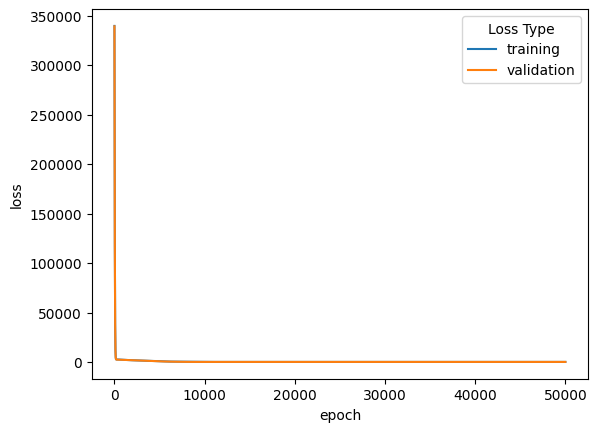

In [ ]:
epochs = 50000
print_every_n = 5000

loss_curve = []

for t in range(epochs):
  training_loss = train(train_dataloader, model, loss_fn, optimizer)
  validation_loss = validate(validation_dataloader, model, loss_fn)
  loss_curve.append([t+1,training_loss,validation_loss])
  # Print the first epoch metric and then print_every_n epochs
  if t==0 or (t+1)%print_every_n == 0:
    print(f"[Epoch {t+1}/{epochs}] training loss: {training_loss} | validation loss: {validation_loss}")
print("Done!")
loss_curve = np.asarray(loss_curve, dtype=np.float32)
plot_loss(loss_curve)

Trained Parameters

In [ ]:
print(f"Slope: {model.weight()}")
print(f"Intercept: {model.bias()}")

Slope: 0.10108526051044464
Intercept: 99.74968719482422


# Model Prediction

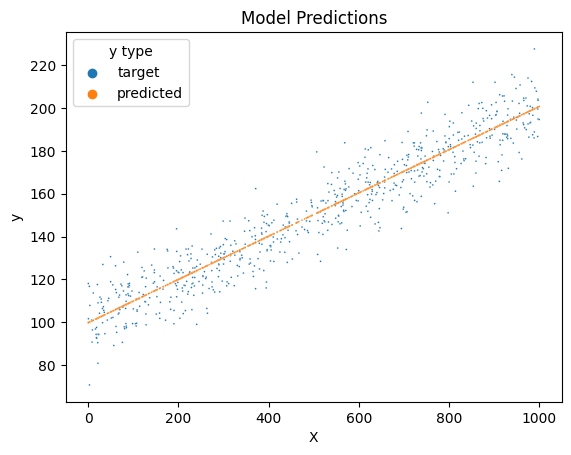

In [ ]:
for batch, (X, y) in enumerate(test_dataloader):
  X, y = X.to(device), y.to(device)
  
  #Forward pass
  with torch.no_grad():
    pred = model(X)
    pred = pred.detach()

  #Plot predictions
  data = torch.stack((X,y,pred),dim=1)
  data = torch.squeeze(data)
  plt.figure(batch)
  plot_predictions(data)